# Bayesian Workflow Demo: Complete NLSQ → NUTS → ArviZ Pipeline

> **Handbook:** See [Complete Bayesian Workflow](../../docs/source/_includes/bayesian_workflow.rst) for step-by-step implementation guide and [Three-Stage Pipeline](../../docs/source/user_guide/03_advanced_topics/bayesian_inference.rst#workflow) for theoretical background.

This notebook demonstrates the recommended three-stage Bayesian workflow:
1. **Stage 1**: NLSQ point estimation (fast, ~seconds)
2. **Stage 2**: NUTS posterior sampling with warm-start (~minutes)
3. **Stage 3**: ArviZ diagnostic plots (visual verification)

## Learning Objectives

After completing this notebook, you will be able to:
- Execute the complete three-stage Bayesian workflow
- Understand warm-start benefits for MCMC convergence
- Interpret posterior summaries and credible intervals
- Use ArviZ for comprehensive MCMC diagnostics
- Apply the workflow to any RheoJAX model

**Estimated Time:** 15-20 minutes

**Expected runtime**: ~30 seconds (depending on hardware)

**Requirements**:
- rheojax with Bayesian dependencies (numpyro, arviz)
- matplotlib for visualization

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rheojax.models import Maxwell

from rheojax.core.jax_config import safe_import_jax

# Safe JAX import (ensures float64 precision)
jax, jnp = safe_import_jax()

print("="*70)
print("BAYESIAN WORKFLOW DEMONSTRATION")
print("="*70)
print("\nThis demo shows the recommended NLSQ → NUTS → ArviZ workflow")
print("for uncertainty quantification in rheological modeling.\n")

import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit, display_arviz_diagnostics, plot_posterior_predictive
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


BAYESIAN WORKFLOW DEMONSTRATION

This demo shows the recommended NLSQ → NUTS → ArviZ workflow
for uncertainty quantification in rheological modeling.



## Step 1: Generate Synthetic Relaxation Data

We'll create synthetic Maxwell relaxation data with realistic noise to demonstrate the workflow.

In [3]:
print("Step 1: Generating synthetic Maxwell relaxation data...")
print("-"*70)

# True parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # 0.01 s

print(f"  True parameters:")
print(f"    G₀  = {G0_true:.2e} Pa")
print(f"    η   = {eta_true:.2e} Pa·s")
print(f"    τ   = {tau_true:.4f} s")

# Time array (log-spaced for relaxation)
t = np.logspace(-2, 2, 50)  # 0.01 to 100 seconds

# True relaxation modulus
G_t_true = G0_true * np.exp(-t / tau_true)

# Add realistic noise (1.5% relative)
np.random.seed(42)
noise_level = 0.015
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"\n  Generated {len(t)} data points from {t.min():.2e} to {t.max():.1f} s")
print(f"  Noise level: {noise_level*100:.1f}% relative")
print(f"  Signal-to-noise ratio: {np.mean(G_t_true)/np.std(noise):.1f}")

Step 1: Generating synthetic Maxwell relaxation data...
----------------------------------------------------------------------
  True parameters:
    G₀  = 1.00e+05 Pa
    η   = 1.00e+03 Pa·s
    τ   = 0.0100 s

  Generated 50 data points from 1.00e-02 to 100.0 s
  Noise level: 1.5% relative
  Signal-to-noise ratio: 36.0


## Stage 1: NLSQ Point Estimation (Fast)

First, we obtain fast point estimates using nonlinear least squares optimization.

In [4]:
print("\n" + "="*70)
print("STAGE 1: NLSQ POINT ESTIMATION")
print("="*70)

model = Maxwell()
model.parameters.set_bounds('G0', (1e3, 1e7))
model.parameters.set_bounds('eta', (1e1, 1e5))

print("\nRunning NLSQ optimization...")
import time

start_nlsq = time.time()

model.fit(t, G_t_noisy, method='nlsq')

nlsq_time = time.time() - start_nlsq

# Extract NLSQ results
G0_nlsq = model.parameters.get_value('G0')
eta_nlsq = model.parameters.get_value('eta')
tau_nlsq = eta_nlsq / G0_nlsq

print(f"\n✓ NLSQ completed in {nlsq_time:.3f} seconds")
print(f"\nNLSQ Point Estimates:")
print(f"  G₀  = {G0_nlsq:.4e} Pa  (error: {abs(G0_nlsq-G0_true)/G0_true*100:.2f}%)")
print(f"  η   = {eta_nlsq:.4e} Pa·s  (error: {abs(eta_nlsq-eta_true)/eta_true*100:.2f}%)")
print(f"  τ   = {tau_nlsq:.6f} s  (error: {abs(tau_nlsq-tau_true)/tau_true*100:.2f}%)")
print(f"\n⚠  Note: NLSQ provides point estimates only (no uncertainty)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06



STAGE 1: NLSQ POINT ESTIMATION

Running NLSQ optimization...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.783230s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.783s | final_gradient_norm=9.8301e-05



✓ NLSQ completed in 1.179 seconds

NLSQ Point Estimates:
  G₀  = 1.0053e+05 Pa  (error: 0.53%)
  η   = 1.0044e+03 Pa·s  (error: 0.44%)
  τ   = 0.009992 s  (error: 0.08%)

⚠  Note: NLSQ provides point estimates only (no uncertainty)


## Stage 2: Bayesian Inference with Warm-Start

Now we perform MCMC sampling using NUTS, warm-starting from the NLSQ estimates for faster convergence.

In [5]:
print("\n" + "="*70)
print("STAGE 2: BAYESIAN INFERENCE (NUTS)")
print("="*70)

print("\nRunning NUTS sampling with NLSQ warm-start...")
print("  Configuration:")
print(f"    • num_chains: 4 (for robust diagnostics)")
print(f"    • num_warmup: 1000 (burn-in iterations)")
print(f"    • num_samples: 2000 (posterior samples per chain)")
print(f"    • warm-start: Yes (from NLSQ estimates)")
print("\n  This may take 20-60 seconds depending on your hardware...")

start_bayes = time.time()

# Run Bayesian inference with warm-start
result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    initial_values={  # Warm-start from NLSQ
        'G0': G0_nlsq,
        'eta': eta_nlsq
    }
)

bayes_time = time.time() - start_bayes

print(f"\n✓ Bayesian inference completed in {bayes_time:.1f} seconds")
print(f"  Total time (NLSQ + Bayes): {nlsq_time + bayes_time:.1f} seconds")
print(f"  Generated {result.num_chains * result.num_samples} posterior samples")


STAGE 2: BAYESIAN INFERENCE (NUTS)

Running NUTS sampling with NLSQ warm-start...
  Configuration:
    • num_chains: 4 (for robust diagnostics)
    • num_warmup: 1000 (burn-in iterations)
    • num_samples: 2000 (posterior samples per chain)
    • warm-start: Yes (from NLSQ estimates)

  This may take 20-60 seconds depending on your hardware...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<42:05,  1.19it/s]

warmup:   0%|          | 2/3000 [00:01<40:40,  1.23it/s]

warmup:   2%|▏         | 67/3000 [00:01<00:47, 61.86it/s]

warmup:   4%|▎         | 109/3000 [00:01<00:27, 103.98it/s]

warmup:   6%|▋         | 190/3000 [00:01<00:13, 205.50it/s]

warmup:  10%|▉         | 293/3000 [00:02<00:07, 345.97it/s]

warmup:  15%|█▍        | 443/3000 [00:02<00:04, 571.91it/s]

warmup:  20%|██        | 609/3000 [00:02<00:02, 808.85it/s]

warmup:  27%|██▋       | 802/3000 [00:02<00:02, 1074.08it/s]

warmup:  33%|███▎      | 982/3000 [00:02<00:01, 1256.88it/s]

sample:  39%|███▊      | 1160/3000 [00:02<00:01, 1395.21it/s]

sample:  44%|████▍     | 1330/3000 [00:02<00:01, 1477.78it/s]

sample:  51%|█████▏    | 1539/3000 [00:02<00:00, 1649.33it/s]

sample:  59%|█████▉    | 1772/3000 [00:02<00:00, 1843.93it/s]

sample:  67%|██████▋   | 2002/3000 [00:02<00:00, 1975.52it/s]

sample:  74%|███████▎  | 2207/3000 [00:03<00:00, 1965.29it/s]

sample:  80%|████████  | 2409/3000 [00:03<00:00, 1906.48it/s]

sample:  88%|████████▊ | 2625/3000 [00:03<00:00, 1978.59it/s]

sample:  94%|█████████▍| 2826/3000 [00:03<00:00, 1916.56it/s]

sample: 100%|██████████| 3000/3000 [00:03<00:00, 864.89it/s] 


✓ Bayesian inference completed in 5.3 seconds
  Total time (NLSQ + Bayes): 6.5 seconds
  Generated 8000 posterior samples


## Posterior Results

Extract and display the posterior summary statistics and credible intervals.

In [6]:
print("\n" + "="*70)
print("POSTERIOR RESULTS")
print("="*70)

posterior = result.posterior_samples
summary = result.summary

print("\nPosterior Estimates (mean ± std):")
print(f"  G₀  = {summary['G0']['mean']:.4e} ± {summary['G0']['std']:.4e} Pa")
print(f"  η   = {summary['eta']['mean']:.4e} ± {summary['eta']['std']:.4e} Pa·s")

# Compute credible intervals
intervals = model.get_credible_intervals(posterior, credibility=0.95)
print("\n95% Credible Intervals:")
print(f"  G₀:  [{intervals['G0'][0]:.4e}, {intervals['G0'][1]:.4e}] Pa")
print(f"  η:   [{intervals['eta'][0]:.4e}, {intervals['eta'][1]:.4e}] Pa·s")

print("\nInterpretation:")
print("  'There is 95% probability that G₀ lies in the interval above'")
print("  This is a DIRECT probabilistic statement (Bayesian interpretation)")

# Relative uncertainties
print("\nRelative Uncertainties:")
print(f"  G₀:  {summary['G0']['std']/summary['G0']['mean']*100:.2f}%")
print(f"  η:   {summary['eta']['std']/summary['eta']['mean']*100:.2f}%")

# Check if true values are in credible intervals
G0_in_CI = intervals['G0'][0] <= G0_true <= intervals['G0'][1]
eta_in_CI = intervals['eta'][0] <= eta_true <= intervals['eta'][1]
print("\nValidation (true values in 95% CI):")
print(f"  G₀:  {'✓ Yes' if G0_in_CI else '✗ No'}")
print(f"  η:   {'✓ Yes' if eta_in_CI else '✗ No'}")


POSTERIOR RESULTS

Posterior Estimates (mean ± std):
  G₀  = 1.0022e+05 ± 3.6778e+02 Pa
  η   = 1.0052e+03 ± 1.3357e+00 Pa·s

95% Credible Intervals:
  G₀:  [9.9531e+04, 1.0096e+05] Pa
  η:   [1.0025e+03, 1.0077e+03] Pa·s

Interpretation:
  'There is 95% probability that G₀ lies in the interval above'
  This is a DIRECT probabilistic statement (Bayesian interpretation)

Relative Uncertainties:
  G₀:  0.37%
  η:   0.13%

Validation (true values in 95% CI):
  G₀:  ✓ Yes
  η:   ✗ No


## Stage 3: Convergence Diagnostics (CRITICAL!)

**Always check convergence before interpreting Bayesian results!**

We examine:
- **R-hat (Gelman-Rubin)**: Should be < 1.01 for all parameters
- **ESS (Effective Sample Size)**: Should be > 400 for reliable inference
- **Divergences**: Should be < 1% of total samples

In [7]:
print("\n" + "="*70)
print("STAGE 3: CONVERGENCE DIAGNOSTICS")
print("="*70)

diagnostics = result.diagnostics

print("\n⚠  ALWAYS check convergence before interpreting Bayesian results!")
print("\n1. R-hat (Gelman-Rubin Statistic):")
print(f"   Target: < 1.01 for all parameters")
for param in ['G0', 'eta']:
    rhat = diagnostics['r_hat'][param]
    status = '✓ Converged' if rhat < 1.01 else '✗ NOT converged'
    print(f"     {param:<5} R-hat = {rhat:.4f}  {status}")

print("\n2. ESS (Effective Sample Size):")
print(f"   Target: > 400 (out of {result.num_chains * result.num_samples} total)")
for param in ['G0', 'eta']:
    ess = diagnostics['ess'][param]
    efficiency = ess / (result.num_chains * result.num_samples) * 100
    status = '✓ Sufficient' if ess > 400 else '✗ Low (increase samples)'
    print(f"     {param:<5} ESS = {ess:.0f} ({efficiency:.1f}% efficient)  {status}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / (result.num_chains * result.num_samples) * 100
    print("\n3. Divergences:")
    print(f"   Count: {diagnostics['num_divergences']} ({div_rate:.2f}%)")
    status = '✓ Good' if div_rate < 1 else '✗ High (results unreliable)'
    print(f"   Target: < 1%  {status}")

# Overall convergence assessment
all_converged = (
    all(diagnostics['r_hat'][p] < 1.01 for p in ['G0', 'eta']) and
    all(diagnostics['ess'][p] > 400 for p in ['G0', 'eta'])
)

print("\n" + "-"*70)
if all_converged:
    print("✓✓✓ EXCELLENT CONVERGENCE ✓✓✓")
    print("All diagnostic criteria met. Results are reliable.")
else:
    print("⚠⚠⚠ CONVERGENCE ISSUES ⚠⚠⚠")
    print("Increase num_warmup or num_samples and rerun.")
print("-"*70)


STAGE 3: CONVERGENCE DIAGNOSTICS

⚠  ALWAYS check convergence before interpreting Bayesian results!

1. R-hat (Gelman-Rubin Statistic):
   Target: < 1.01 for all parameters
     G0    R-hat = 1.0006  ✓ Converged
     eta   R-hat = 1.0004  ✓ Converged

2. ESS (Effective Sample Size):
   Target: > 400 (out of 8000 total)
     G0    ESS = 3701 (46.3% efficient)  ✓ Sufficient
     eta   ESS = 4442 (55.5% efficient)  ✓ Sufficient

----------------------------------------------------------------------
✓✓✓ EXCELLENT CONVERGENCE ✓✓✓
All diagnostic criteria met. Results are reliable.
----------------------------------------------------------------------


## Visual Diagnostics (ArviZ Integration)

ArviZ provides comprehensive diagnostic visualizations. We'll generate 6 key plots:

1. **Trace plot**: Visual convergence check
2. **Rank plot**: Most sensitive convergence test
3. **Pair plot**: Parameter correlations + divergences
4. **Autocorrelation plot**: Mixing quality
5. **ESS plot**: Sampling efficiency
6. **Forest plot**: Credible interval comparison

In [8]:
print("\n" + "="*70)
print("VISUAL DIAGNOSTICS (ArviZ Integration)")
print("="*70)

print("\nGenerating diagnostic plots...")

# Convert to ArviZ InferenceData

idata = result.to_inference_data()


VISUAL DIAGNOSTICS (ArviZ Integration)

Generating diagnostic plots...


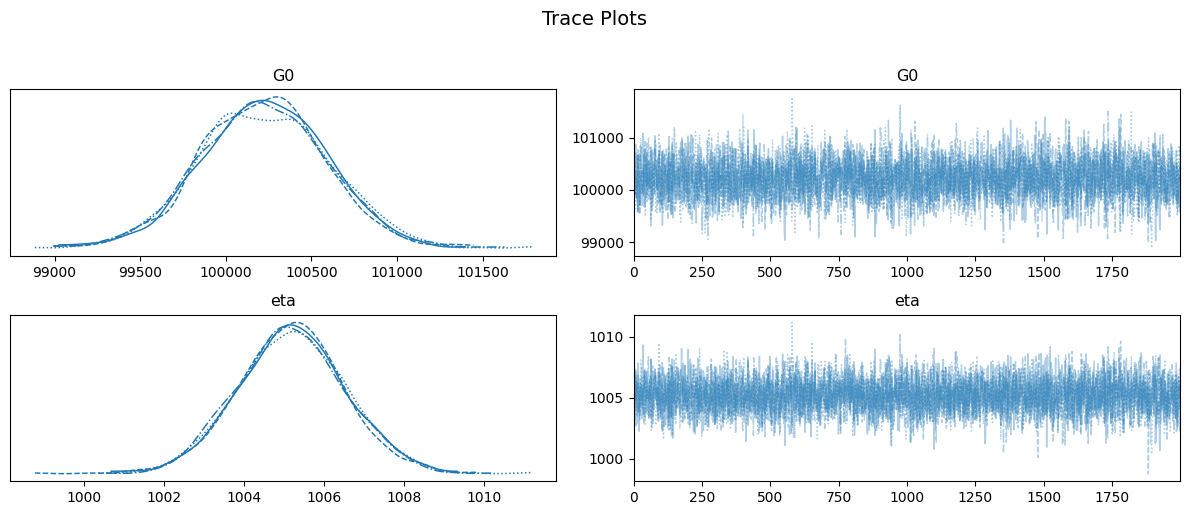

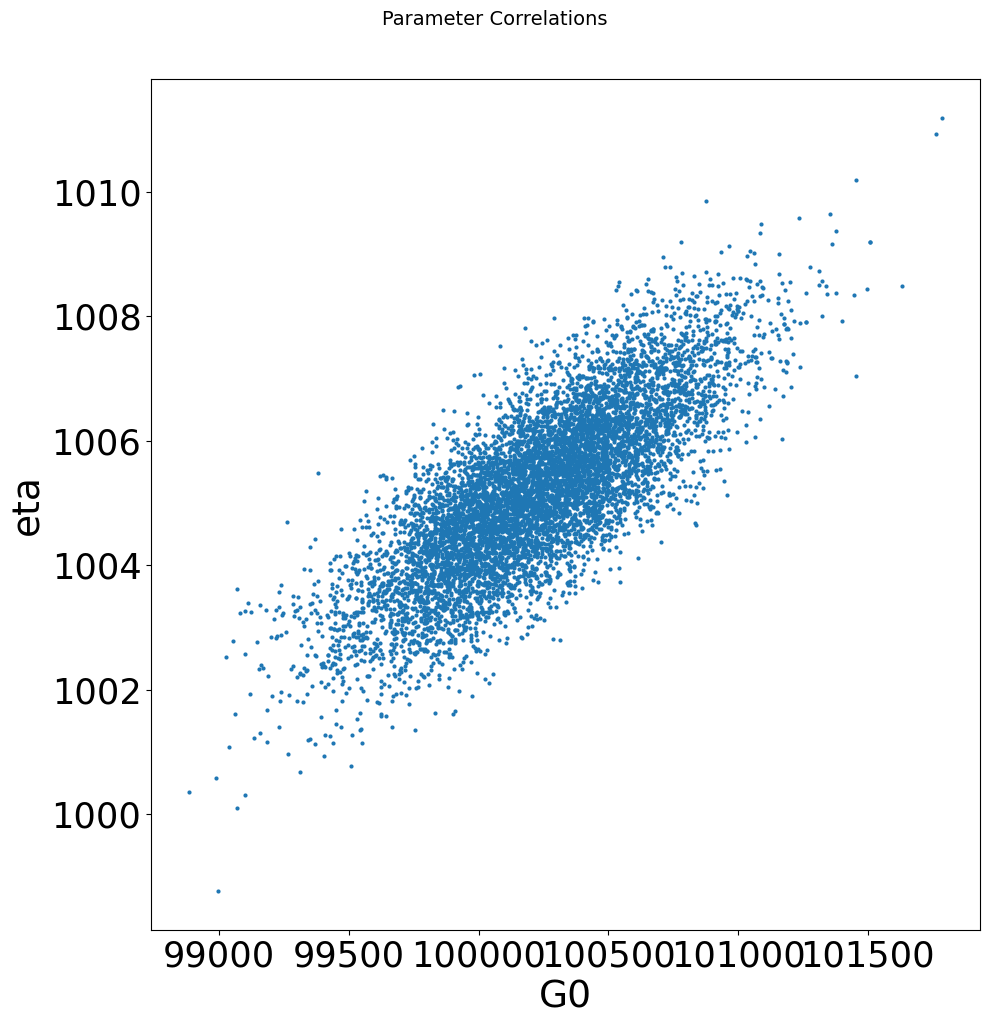

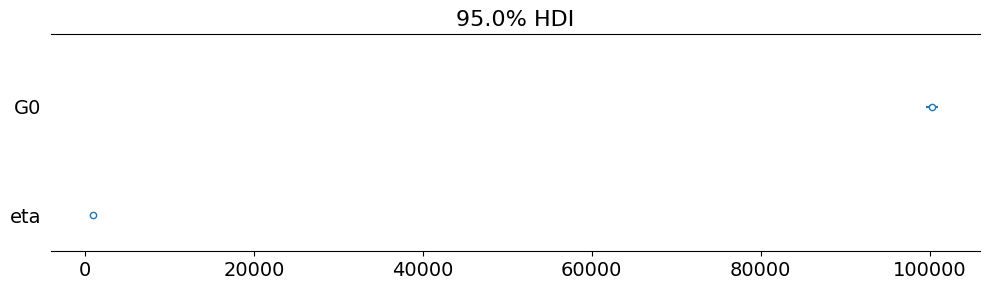

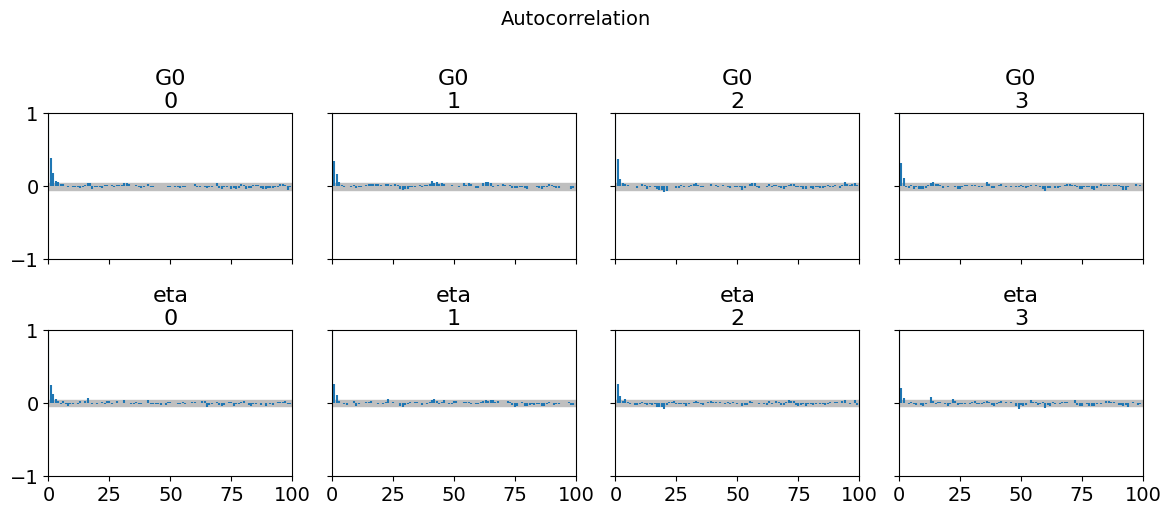

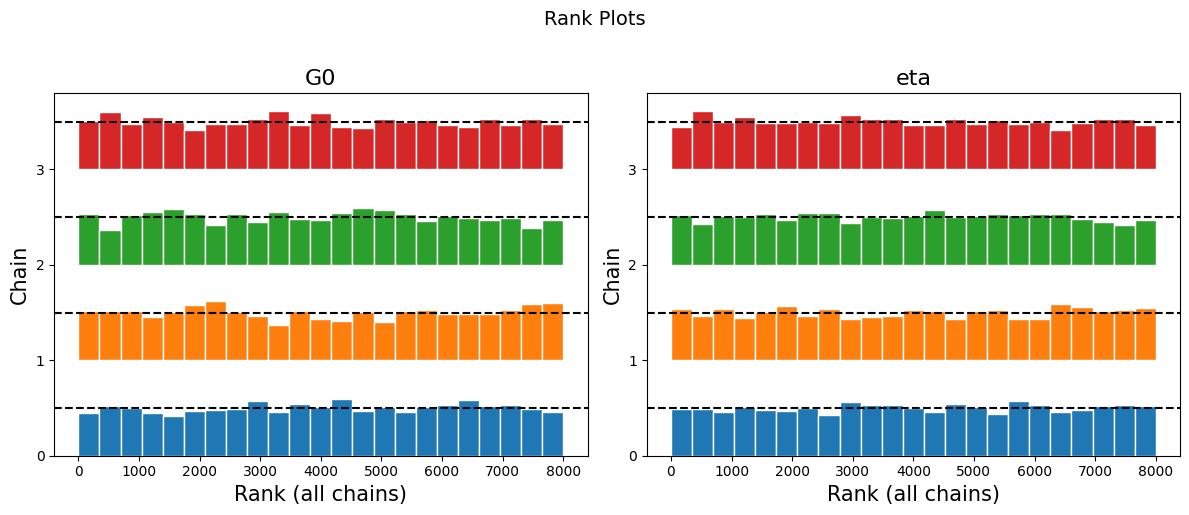

In [9]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['G0', 'eta'], fast_mode=FAST_MODE)

## Workflow Summary

Recap of the complete 3-stage workflow and key results.

### Residual Analysis in Workflow

**Examining residuals** at each stage reveals model adequacy:

| Workflow Stage | Residual Check | Interpretation |
|----------------|----------------|----------------|
| **Stage 1 (NLSQ)** | Quick visual check | Random scatter → proceed to Bayesian |
| **Stage 2 (NUTS)** | Posterior predictive | Bands capture data → model adequate |
| **Stage 3 (ArviZ)** | Diagnostic plots | No systematic patterns → converged |

If residuals show systematic patterns (trends, heteroscedasticity), consider:
- Different model (e.g., Zener instead of Maxwell)
- Additional parameters
- Weighted least squares for non-constant variance

## Further Reading

- **Gelman et al. (2020)**: ["Bayesian Workflow"](https://arxiv.org/abs/1507.03246) — Comprehensive workflow for applied Bayesian modeling
- **Betancourt (2018)**: ["Towards a Principled Bayesian Workflow"](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) — Deep dive into workflow stages
- **RheoJAX Bayesian Guide**: [Documentation](../../docs/source/_includes/bayesian_workflow.rst) — Implementation details and best practices
- **ArviZ Workflow Tools**: [Tutorial](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html) — Using InferenceData for analysis

## Next Steps

- **[07-gmm_bayesian_workflow.ipynb](07-gmm_bayesian_workflow.ipynb)**: Apply workflow to multi-mode Generalized Maxwell models
- **[08-spp-laos.ipynb](08-spp-laos.ipynb)** & **[09-spp-rheojax-workflow.ipynb](09-spp-rheojax-workflow.ipynb)**: Workflow for nonlinear LAOS analysis
- Adapt this workflow template to your own rheological datasets

**For questions or issues:**
- GitHub: https://github.com/imewei/rheojax
- Docs: https://rheojax.readthedocs.io

### Key References

- **Gelman, A. et al. (2020).** "Bayesian Workflow." arXiv:2011.01808. [Modern best practices for applied Bayesian analysis]
- **McElreath, R. (2020).** *Statistical Rethinking*. 2nd ed. CRC Press. [Complete workflow with practical examples]
- **Gabry, J. et al. (2019).** "Visualization in Bayesian workflow." *J. Royal Stat. Soc. A* 182:389-402. [Diagnostic visualization strategies]